In [134]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
from dataclasses import *
import numpy as np
from typing import Dict 
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
import scipy.integrate as integrate
from EnforceTyping import EnforceClassTyping, EnforceFunctionTyping, EnforceMethodTyping
from ParticlesandFields import Particle, Field


In [135]:
NegativeCharge= Particle(Mass=1.0, Charge= -1e-5)
PositiveCharge= Particle(Mass=10.0, Charge= 1e-5)
Sources = {"Particle": [NegativeCharge],
          "Position": [np.array([1.0, 1.0])]}

In [136]:
@dataclass(kw_only= True)
class ElectricField(Field):
  FieldSources: Dict

  def __call__(self, ObservationPosition: np.ndarray)->np.ndarray:
      return self.FieldStrength(ObservationPosition)
  @EnforceMethodTyping
  def FieldStrength(self, ObservationPosition: np.ndarray)->np.ndarray:
    'This function outputs the field strength due to Field Sources experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = np.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], 
                                           self.FieldSources["Position"]):
      PositionMatrices= np.stack([np.full(ObservationPosition.shape[1:], SourcePosition[0]), 
                                  np.full(ObservationPosition.shape[1:], SourcePosition[1])])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = np.linalg.norm(DisplacementVector, axis=0)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**2
    return CoulombConstant * ElectricFieldVector #N/C or V/m
  @EnforceMethodTyping
  def FieldPotential(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray, resolution: int= 5000)-> float:
      '''This method determines the amount of work required to get one position to another in the field'''
      XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
      YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
      XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
      YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
      WorkDone = 0
      for i in range(resolution):
          PositionFieldStrength = self.FieldStrength(np.array([XPositions[i], YPositions[i]]))
          WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
      return WorkDone
  @EnforceMethodTyping
  def PlotField(self, LowBound= -20, HighBound= 20):
      'This funtion plots the 2D electric vector field'
      ObservationPosition= np.meshgrid(np.linspace(LowBound, HighBound, 50), 
                                      np.linspace(LowBound, HighBound, 50))
      ObservationPosition= np.stack(ObservationPosition)
      xd, yd = self.FieldStrength(ObservationPosition)
      xd = xd / np.sqrt(xd**2 + yd**2)
      yd = yd / np.sqrt(xd**2 + yd**2)
      color_aara = np.sqrt(xd**2+ yd**2)
      fig, ax = plt.subplots(1,1)
      cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
      fig.colorbar(cp)
      plt.rcParams['figure.dpi'] = 250
      plt.show()
  def Derivative(self, ObservationPosition):
    'This function returns the derivative of the field at a given point'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = np.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= np.stack([np.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                np.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = np.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**1.5
    return -CoulombConstant * ElectricFieldVector

In [137]:
class HomogenousField(Field):
  def FieldStrength(self, ObservationPosition: np.ndarray)-> np.ndarray:
    return  np.zeros((ObservationPosition.shape[0], self.Dimensions), dtype=np.float64)
  def FieldPotential(self, ObservationPosition: np.ndarray)-> float:
    return  0.0

@dataclass(kw_only= True)
class LJField(Field):
    FieldSources: list[Particle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: np.ndarray)->np.ndarray:
        return self.FieldStrength(ObservationPosition)
    @EnforceMethodTyping
    def FieldStrength(self, ObservationPosition: np.ndarray)->np.ndarray:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != Particle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == np.ndarray, "Invalid Reference point data type"
        ElectricFieldVector = np.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= np.stack([np.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            np.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = np.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += ((FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector) - ((FieldSource.Charge) / DisplacementMagnitude**6 * DisplacementVector)
        ElectricFieldVector= CoulombConstant *ElectricFieldVector
        return ElectricFieldVector #N/C or V/m
    @EnforceMethodTyping
    def FieldPotential(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ForceFieldStrength(np.array([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @EnforceMethodTyping
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= np.meshgrid(np.linspace(self.FieldLowBound, self.FieldHighBound, 40), 
                                        np.linspace(self.FieldLowBound, self.FieldHighBound, 40))
        ObservationPosition= np.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / np.sqrt(xd**2 + yd**2)
        yd = yd / np.sqrt(xd**2 + yd**2)
        color_aara = np.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()


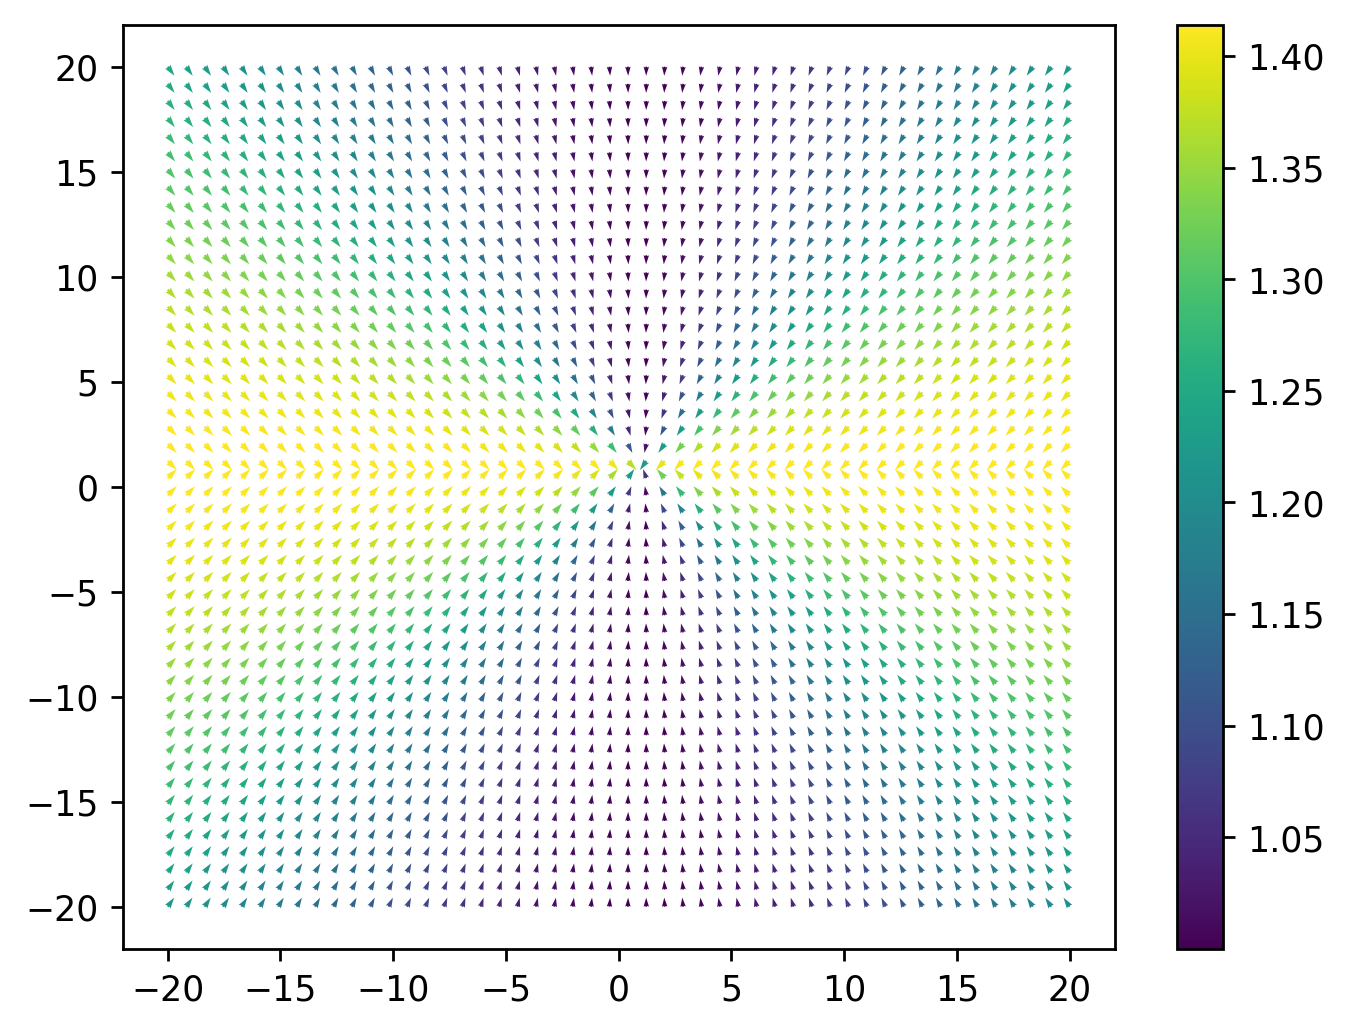

In [138]:
TestElectricField= ElectricField(FieldSources=Sources)
TestElectricField.PlotField()

In [139]:
a= np.zeros((2, 3, 3))
b= np.array([0.0, 0.0])
c= np.array([1.0, 1.0])
TestPotential= lambda x, y: TestElectricField.FieldStrength(np.array([x, y])) 
TestElectricField.FieldPotential(b, c), integrate.nquad(TestPotential, [[0.0, 0.0], [1.0, 1.0]])

TypeError: only length-1 arrays can be converted to Python scalars